In [1]:
import seaborn as sns
import pandas as pd 
import numpy as np
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
import torch
import anndata as an
import scanpy as sc
import umap
import gc
from importlib import reload

from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor
import geneformer

# local imports
import geneformer_utils as gtu

sns.set_style('white')

/home/oliven/miniconda3/envs/geneformer2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# break

In [3]:
# model = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
model = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
# data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/rajapakse_lab_data.dataset"
# data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/tabula_sapiens_muscle.dataset"
data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset"
outpath = "/scratch/indikar_root/indikar0/cstansbu/geneformer"

In [4]:
reload(gtu)
df = gtu.load_data_as_dataframe(data_path, num_cells=10, shuffle=True)
print(f"{df.shape=}")
df.head()

df.shape=(10, 8)


,input_ids,length,cell_type,individual,age,sex,disease,lvef
0,"[11045, 176, 8088, 5053, 13408, 4476, 14768, 1...",794,Fibroblast1,1304,63.0,Female,dcm,10.0
1,"[20495, 2693, 9756, 11142, 21009, 3842, 383, 1...",432,Endothelial1,1422,54.0,Male,hcm,70.0
2,"[17173, 4285, 10716, 6073, 9837, 3707, 403, 13...",1130,Cardiomyocyte1,1603,69.0,Female,nf,NaN
3,"[6633, 3373, 1329, 708, 15961, 8411, 2053, 162...",1287,Macrophage,1718,33.0,Male,nf,55.0
4,"[85, 7258, 9695, 5306, 4072, 3605, 5347, 5572,...",1017,Fibroblast1,1430,62.0,Male,dcm,15.0


In [5]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

# Original Geneformer Extraction

In [6]:
torch.cuda.empty_cache()

n_cells = 1000
# 0 for last layer, -1 for second to last
layer = -1

# initiate EmbExtractor
embex = EmbExtractor(model_type="Pretrained",
                     num_classes=0,
                     max_ncells=n_cells,
                     emb_mode='cell',
                     emb_layer=layer,
                     emb_label=["cell_type",],
                     forward_batch_size=30,
                     nproc=16,
                      )

# extracts embedding from input data
embs = embex.extract_embs(model,
                          data_path,
                          outpath,
                          "test")

embs.head()

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [7]:
# translate into an anndata object and plot
adata = gtu.embedding_to_adata(embs)
adata

NameError: name 'embs' is not defined

In [ ]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(
    adata,
    color=["cell_type"],
    ncols=1,
    # Setting a smaller point size to get prevent overlap
    size=30,
)

In [ ]:
# break

# in-memory embedding extraction

In [7]:
reload(gtu)
model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
model = gtu.load_model(model_path)
type(model)

Some weights of BertForMaskedLM were not initialized from the model checkpoint at /nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/ and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/rajapakse_lab_data.dataset"
data = load_from_disk(data_path)
type(data)

In [17]:
reload(gtu)
token_path = gtu.DEFAULT_TOKEN_PATH
tokens = gtu.load_pickle(token_path)
print(tokens.get("<pad>"))
# len(tokens)

0


In [18]:
reload(gtu)
embs = gtu.extract_embedding_in_mem(model, data)
embs.head()

AttributeError: 'str' object has no attribute 'bert'

# a simple perturbation example



In [16]:
token_data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/token_mappings.csv"
token_df = pd.read_csv(token_data_path)
token_df.head()

,gene_id,token_id,gene_name,nonzero_median,gene_version,gene_biotype,Chromosome,Start,End,scenic_tf
0,<pad>,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,<mask>,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,ENSG00000000003,2,TSPAN6,2.001186,15.0,protein_coding,X,100627107.0,100639991.0,False
3,ENSG00000000005,3,TNMD,3.228213,6.0,protein_coding,X,100584935.0,100599885.0,False
4,ENSG00000000419,4,DPM1,2.218874,14.0,protein_coding,20,50934866.0,50959140.0,False


In [17]:
# extract the yamanaka factors
query_genes = [
    'POU5F1', # oct4
    'SOX2',
    'KLF4',
    'MYC'   
]

genes = token_df[token_df['gene_name'].isin(query_genes)]
force_tokens = genes['token_id'].to_list()
genes

,gene_id,token_id,gene_name,nonzero_median,gene_version,gene_biotype,Chromosome,Start,End,scenic_tf
7301,ENSG00000136826,7301,KLF4,3.854239,15.0,protein_coding,9,107484851.0,107490482.0,True
7352,ENSG00000136997,7352,MYC,3.453890,21.0,protein_coding,8,127735433.0,127742951.0,True
14712,ENSG00000181449,14712,SOX2,6.858042,4.0,protein_coding,3,181711924.0,181714436.0,True
17679,ENSG00000204531,17679,POU5F1,3.540753,21.0,protein_coding,6,31164336.0,31180731.0,True


In [23]:
# convert the arrow dataset to a dataframe
raw_data = data.to_pandas()
raw_data['type'] = 'raw'
print(raw_data[['input_ids']].head())
print(raw_data[['input_ids']].shape)

# perturb the cells
perturbed = raw_data.copy()
perturbed['type'] = 'perturbed'
perturbed['input_ids'] = perturbed['input_ids'].apply(lambda x: list(force_tokens) + list(x)[:len(x) - len(force_tokens)])
print(perturbed[['input_ids']].head())

# join the data back together
#check on the dimensions of this it seems sus perhaps like there are copies of everything
df = pd.concat([raw_data, perturbed])
print(f"{df.shape=}")
#df.head()

                                           input_ids
0  [10920, 4415, 7492, 11900, 11350, 10027, 3584,...
1  [4415, 10920, 7492, 10027, 11350, 3584, 1732, ...
2  [4415, 10920, 7492, 2852, 10027, 11350, 3584, ...
3  [7492, 4415, 10920, 9235, 6013, 6839, 10939, 5...
4  [7492, 4415, 10920, 11900, 16683, 10027, 6013,...
(66, 1)
                                           input_ids
0  [7301, 7352, 14712, 17679, 10920, 4415, 7492, ...
1  [7301, 7352, 14712, 17679, 4415, 10920, 7492, ...
2  [7301, 7352, 14712, 17679, 4415, 10920, 7492, ...
3  [7301, 7352, 14712, 17679, 7492, 4415, 10920, ...
4  [7301, 7352, 14712, 17679, 7492, 4415, 10920, ...
df.shape=(132, 9)


In [ ]:
# The input id lists are just 128 + 4.  That can't be a coincidence, why were there 

In [19]:
# convert back into arrow dataset
new_data = Dataset.from_pandas(df)

# extract embeddings 
embs = gtu.extract_embedding_in_mem(model, new_data)
embs.head()

100%|██████████| 14/14 [00:01<00:00, 13.38it/s]


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,2.979183,0.178517,0.188426,0.126767,0.054358,1.263473,0.146052,-0.803534,0.400076,-1.905356,...,0.832997,0.329420,-0.378388,1.103023,-1.227957,1.602475,0.533580,-0.425285,1.339452,-2.345872
1,2.994610,0.428593,0.266766,0.070220,0.052456,1.262768,0.212589,-0.852712,0.475181,-1.983257,...,0.750081,0.345057,-0.335371,1.074961,-1.261357,1.513204,0.412000,-0.420056,1.283152,-2.388969
2,2.995043,0.328111,0.277155,0.180654,-0.012740,1.330186,0.128360,-0.834138,0.455106,-2.073669,...,0.694448,0.367784,-0.341777,1.121613,-1.252905,1.408749,0.423753,-0.430617,1.296298,-2.425880
3,3.040588,0.043143,0.172200,0.030262,0.052932,1.182893,0.165487,-0.770852,0.325189,-1.666766,...,0.910159,0.170595,-0.392468,1.130279,-1.159098,1.763494,0.613409,-0.385079,1.314380,-2.093091
4,2.991683,0.434422,0.203075,0.017746,0.066662,1.205739,0.190587,-0.779800,0.443083,-1.873510,...,0.825267,0.259383,-0.336455,1.109637,-1.246545,1.608525,0.482107,-0.358869,1.308622,-2.219175


/home/oliven/miniconda3/envs/geneformer2/lib/python3.10/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


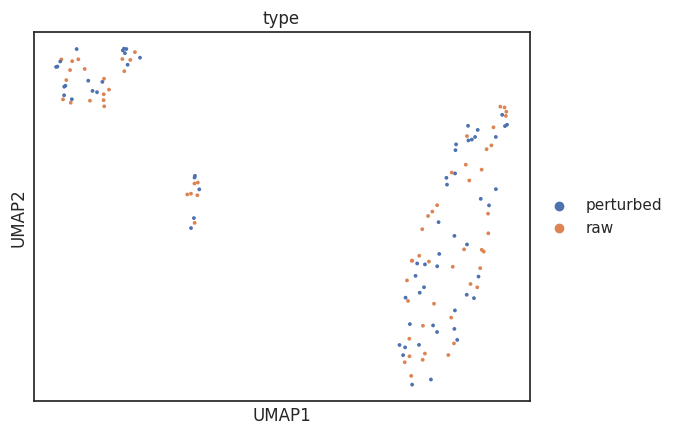

In [20]:
reload(gtu)
adata = gtu.make_embedding_anndata(embs, df)

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(
    adata,
    color=["type"],
    ncols=1,
    # Setting a smaller point size to get prevent overlap
    size=30,
)

# Archive

In [ ]:
break

# Neighbor Graph (no PCA of embeddings)

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=["cell_type", "dataset"],
    n_cols=1,
    # Setting a smaller point size to get prevent overlap
    size=10,
)

In [ ]:
break

In [ ]:
comp_1 = 4
comp_2 = 5

sns.scatterplot(data=embs,
                x=comp_1,
                y=comp_2,
                ec='none',
                lw=0.1,
                alpha=0.9,
                hue='dataset',
                s=5)


plt.xticks([])
plt.yticks([])

sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.7, 1))

plt.gca().set_aspect('equal')

In [ ]:
sc.tl.pca(adata, n_comps=5)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color="cell_type",
    # Setting a smaller point size to get prevent overlap
    size=10,
)

In [ ]:
break

In [ ]:
sc.tl.leiden(adata, n_iterations=2)
sc.pl.umap(adata, color=["leiden"])

In [ ]:
break

In [ ]:
sns.scatterplot(data=embs,
                x=0,
                y=1,
                hue='dataset',
                s=10)

sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.7, 1))

plt.gca().set_aspect('equal')

In [ ]:
break

In [ ]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=21)
sc.tl.umap(adata, min_dist=0.2)

adata

In [ ]:
sc.pl.umap(adata, 
           color=['dataset'])

In [ ]:
break

In [ ]:
df = embs.copy()

sns.scatterplot(data=df,  
                x=0,
                y=2,
                alpha=0.6,
                s=10,
                palette="Set1",
                # legend=False,
                hue='dataset')

sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.4, 1))
